In [1]:
import torch
import numpy as np
# from sklearn.linear_model import Ridge
from himalaya.ridge import Ridge, RidgeCV
from himalaya.backend import set_backend
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cpu")
import matplotlib.pyplot as plt

In [ ]:
GOD_train_brain_signals = torch.load('/GOD/subjectwise/train_brain_signals_sub1.pt').to(device)
GOD_test_brain_signals = torch.load('/GOD/subjectwise/test_brain_signals_sub1.pt').to(device)


GOD_train_image_embds = torch.load('/GOD/train_image_embeddings.pt').to(device)
GOD_test_image_embds = torch.load('/GOD/test_image_embeddings.pt').to(device)

GOD_train_image_embds = GOD_train_image_embds[:, 1, 0].float()
GOD_test_image_embds = GOD_test_image_embds[:, 1, 0].float()



In [41]:

X_train = GOD_train_image_embds[:1200].numpy()
X_test = GOD_test_image_embds[:50].numpy()

Y_train= GOD_train_brain_signals.numpy()
Y_test = GOD_test_brain_signals.numpy()



# X_train = GOD_train_image_embds[1200:2400].numpy()
# X_test = GOD_test_image_embds[50:100].numpy()

# Y_train= GOD_train_brain_signals[1200:2400].numpy()
# Y_test = GOD_test_brain_signals[50:100].numpy()


# X_train = GOD_train_image_embds[2400:3600].numpy()
# X_test = GOD_test_image_embds[100:150].numpy()

# Y_train= GOD_train_brain_signals[2400:3600].numpy()
# Y_test = GOD_test_brain_signals[100:150].numpy()


# X_train = GOD_train_image_embds[3600:4800].numpy()
# X_test = GOD_test_image_embds[150:200].numpy()

# Y_train= GOD_train_brain_signals[3600:4800].numpy()
# Y_test = GOD_test_brain_signals[150:200].numpy()



# X_train = GOD_train_image_embds[4800:].numpy()
# X_test = GOD_test_image_embds[200:].numpy()

# Y_train= GOD_train_brain_signals[4800:].numpy()
# Y_test = GOD_test_brain_signals[200:].numpy()



In [42]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1200, 1280), (50, 1280), (1200, 4466), (50, 4466))

In [43]:
set_backend("torch_cuda")

ridge = Ridge(alpha=50000.0) 
ridge.fit(X_train, Y_train)

Y_pred = ridge.predict(X_test)


r2 = r2_score(Y_test, Y_pred, multioutput='uniform_average')
print(f"R² Score on Test Data: {r2:.4f}")


voxel_correlations = np.array([
    pearsonr(Y_test[:, v], Y_pred[:, v])[0] if np.std(Y_test[:, v]) > 0 else 0 for v in range(Y_test.shape[1])])


mean_voxel_corr = np.median(voxel_correlations)
print(f"Median Voxel-wise Correlation: {mean_voxel_corr:.4f}")

R² Score on Test Data: -0.0475
Median Voxel-wise Correlation: 0.1102


In [103]:
res  = ((Y_test-Y_pred.numpy())**2).mean(0)

(array([6331., 6906., 1179.,  528.,  333.,  207.,  117.,   54.,   51.,
          18.]),
 array([0.        , 0.03166157, 0.06332313, 0.0949847 , 0.12664626,
        0.15830783, 0.18996939, 0.22163096, 0.25329253, 0.28495409,
        0.31661566]),
 <BarContainer object of 10 artists>)

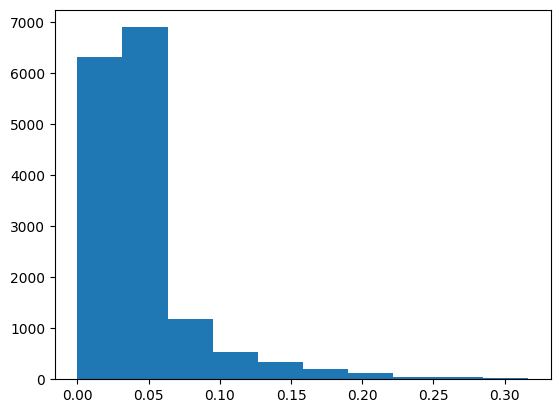

In [104]:
plt.hist(res)

(array([  42.,  219., 1029., 4861., 3321., 2994., 1788.,  879.,  441.,
         150.]),
 array([-0.43968391, -0.31260365, -0.18552338, -0.05844312,  0.06863715,
         0.19571741,  0.32279768,  0.44987794,  0.57695821,  0.70403847,
         0.83111874]),
 <BarContainer object of 10 artists>)

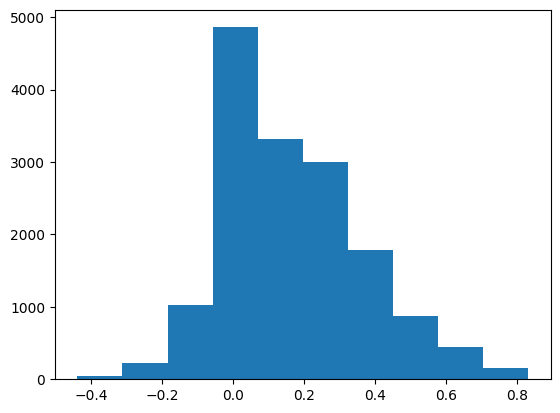

In [105]:
plt.hist(voxel_correlations)

In [ ]:
aug_image_embds = torch.load("/decoding_NSD/data_augmentation/image_embeddings.pt")
aug_image_embds = aug_image_embds[:, 1, 0].float()

aug_image_embds.shape

torch.Size([8859, 1280])

In [107]:
subj2_pred = ridge.predict(aug_image_embds)

In [108]:
subj2_pred.shape

torch.Size([8859, 15724])

In [117]:
from scipy.stats import rv_histogram

# Example histogram data (assuming a histogram was computed)
hist_data = np.histogram(res, bins=5, density=True)

# Create a continuous distribution from the histogram
hist_dist = rv_histogram(hist_data)

# Sample from the distribution
samples = hist_dist.rvs(size=subj2_pred.shape)
print(samples.mean())
print(samples.std())


noise_scale = 1.0


subj1_pred_noise = subj2_pred + samples*noise_scale

0.04606498570997612
0.04227290886566597


In [ ]:
torch.save(subj1_pred_noise, "/GOD/GOD_data_aug/100_percent/subject5.pt")

In [ ]:
# import torch
# import torchvision.transforms as transforms
# from torchvision.datasets import ImageFolder
# from torch.utils.data import DataLoader, Subset
# import random
# import os


# dataset_path = "/imageNet/ilsvrc2012/versions/1"  
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  
#     transforms.ToTensor(),         
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
# ])


# dataset = ImageFolder(root=dataset_path, transform=transform)


# random_indices = random.sample(range(len(dataset)), 8859)


# subset = Subset(dataset, random_indices)


# dataloader = DataLoader(subset, batch_size=64, shuffle=False)  # Adjust batch size as needed


# image_tensors = []
# for images, _ in dataloader:
#     image_tensors.append(images)


# final_tensor = torch.cat(image_tensors, dim=0)  # Shape: (8859, 3, 224, 224)


# torch.save(final_tensor, "decoding_NSD/data_augmentation/selected_images.pt")



In [ ]:
subj1_aug = torch.load("/GOD/GOD_data_aug/100_percent/subject1.pt")
subj2_aug = torch.load("/GOD/GOD_data_aug/100_percent/subject2.pt")
subj3_aug = torch.load("/GOD/GOD_data_aug/100_percent/subject3.pt")
subj4_aug = torch.load("/GOD/GOD_data_aug/100_percent/subject4.pt")
subj5_aug = torch.load("/GOD/GOD_data_aug/100_percent/subject5.pt")


In [242]:
subj1 = GOD_train_brain_signals[:1200]
subj2 = GOD_train_brain_signals[1200:2400]
subj3 = GOD_train_brain_signals[2400:3600]
subj4 = GOD_train_brain_signals[3600:4800]
subj5 = GOD_train_brain_signals[4800:]

subj1.shape, subj2.shape, subj3.shape, subj4.shape, subj5.shape

(torch.Size([1200, 15724]),
 torch.Size([1200, 15724]),
 torch.Size([1200, 15724]),
 torch.Size([1200, 15724]),
 torch.Size([1200, 15724]))

In [243]:
subject1 = torch.cat((subj1, subj1_aug[:900]), dim=0)
subject2 = torch.cat((subj2, subj2_aug[:900]), dim=0)
subject3 = torch.cat((subj3, subj3_aug[:900]), dim=0)
subject4 = torch.cat((subj4, subj4_aug[:900]), dim=0)
subject5 = torch.cat((subj5, subj5_aug[:900]), dim=0)

subject1.shape, subject2.shape, subject3.shape, subject4.shape, subject5.shape

(torch.Size([2100, 15724]),
 torch.Size([2100, 15724]),
 torch.Size([2100, 15724]),
 torch.Size([2100, 15724]),
 torch.Size([2100, 15724]))

In [244]:
train_100percent_noise_10 = torch.cat((subject1, subject2, subject3, subject4, subject5), dim=0)
train_100percent_noise_10.shape

torch.Size([10500, 15724])

In [ ]:
torch.save(train_100percent_noise_10, "/GOD/GOD_data_aug/train_75percent_noise_100.pt")

In [221]:
subj1_image_embds = GOD_train_image_embds[:1200]
subj2_image_embds = GOD_train_image_embds[1200:2400]
subj3_image_embds = GOD_train_image_embds[2400:3600]
subj4_image_embds= GOD_train_image_embds[3600:4800]
subj5_image_embds= GOD_train_image_embds[4800:]

subj1_image_embds.shape, subj2_image_embds.shape, subj3_image_embds.shape, subj4_image_embds.shape, subj5_image_embds.shape

(torch.Size([1200, 2, 1, 1280]),
 torch.Size([1200, 2, 1, 1280]),
 torch.Size([1200, 2, 1, 1280]),
 torch.Size([1200, 2, 1, 1280]),
 torch.Size([1200, 2, 1, 1280]))

In [ ]:
aug_image_embds = torch.load("/decoding_NSD/data_augmentation/image_embeddings.pt").to(device)

In [223]:
subj1_image_embds = torch.cat((subj1_image_embds, aug_image_embds[:900]), dim=0)
subj2_image_embds = torch.cat((subj2_image_embds, aug_image_embds[:900]), dim=0)
subj3_image_embds = torch.cat((subj3_image_embds, aug_image_embds[:900]), dim=0)
subj4_image_embds= torch.cat((subj4_image_embds, aug_image_embds[:900]), dim=0)
subj5_image_embds= torch.cat((subj5_image_embds, aug_image_embds[:900]), dim=0)

train_img_embeds = torch.cat((subj1_image_embds, subj2_image_embds, subj3_image_embds, subj4_image_embds, subj5_image_embds), dim=0)

train_img_embeds.shape

torch.Size([10500, 2, 1, 1280])

In [ ]:
torch.save(train_img_embeds, "/GOD/GOD_data_aug/train_embds_75percent.pt")

In [ ]:

subject_ids = []


subject_ids.extend([12] * 2100)  
subject_ids.extend([13] * 2100)  
subject_ids.extend([14] * 2100) 
subject_ids.extend([15] * 2100) 
subject_ids.extend([16] * 2100) 


subject_ids_tensor = torch.tensor(subject_ids)
torch.save(subject_ids, "/GOD/GOD_data_aug/train_ids_75percent.pt")

subject_ids_tensor

tensor([12, 12, 12,  ..., 16, 16, 16])